# Imports

In [1]:
import numpy as np
import sympy as sy
import re
import csv

import matplotlib.pyplot as plt
import matplotlib.colors as c
from matplotlib.ticker import PercentFormatter
from matplotlib import rcParams
import scipy.constants as pc
from sympy import *
from math import log10, floor
from math import *
import math

from scipy.optimize import curve_fit
from scipy.optimize import minimize

rcParams['font.size'] = 15
rcParams['font.weight'] = 'bold'
rcParams['text.usetex'] = True
rcParams['axes.grid'] = True
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']
rcParams['xtick.labelsize'] = 18
rcParams['ytick.labelsize'] = 18
rcParams["xtick.minor.size"] =  4
rcParams["ytick.minor.size"] =  4
rcParams["xtick.minor.visible"] =  True
rcParams["ytick.minor.visible"] =  True

# Selfcoded functions

In [2]:
def am(werte):
    return np.mean(werte)

def std(werte):
    summen_der_quadrate = 0
    for wert in werte:
        summen_der_quadrate+=(wert-am(werte))**2       
    return np.sqrt(summen_der_quadrate/(werte.size-1))

def stu(werte):
    return std(werte)/np.sqrt(werte.size)

def fehler(f, werte, unsicherheiten, variablen):
    zMax = 0
    for i in range(werte.size):
        dif = np.abs(sy.diff(f, variablen[i]))
        zMax += (dif * unsicherheiten[i])**2
    zMax = sqrt(zMax)
    for j in range(werte.size):
        zMax = sub(zMax, variablen[j], werte[j])
    return zMax

def fehlerMax(f, werte, unsicherheiten, variablen):
    zMax = 0
    for i in range(werte.size):
        dif = np.abs(sy.diff(f, variablen[i]))
        zMax += dif * unsicherheiten[i]
    for j in range(werte.size):
        zMax = sub(zMax, variablen[j], werte[j])
    return zMax

def groessterBeitrag(f, werte, unsicherheiten, variablen):
    zMax = 0
    zMaxArray = np.array([])
    for i in range (werte.size):
        zMax = (np.abs(sy.diff(f, variablen[i])) * unsicherheiten[i])
        for j in range(werte.size):
            zMax = sub(zMax, variablen[j], werte[j])
        x = np.array([zMax])
        zMaxArray = np.append(zMaxArray, x)
    return variablen[np.argmax(zMaxArray)], zMaxArray[np.argmax(zMaxArray)]

def sub(zMax, variable, wert):
    return zMax.subs([(variable, wert)])

def einfachGaussAdd(unsicherheiten, koeffizienten):
    dz = 0
    for i in range (unsicherheiten.size):
        dz += (koeffizienten[i]*unsicherheiten[i])**2
    return sqrt(dz)

def einfachGaussMult(unsicherheiten, werte, exponenten):
    dz = 0
    for i in range (unsicherheiten.size):
        dz += (exponenten[i]*unsicherheiten[i]/werte[i])**2
    return sqrt(dz)

def einfachGaussMultMax(unsicherheiten, werte, exponenten):
    max_a = 0
    num = -1
    for i in range (unsicherheiten.size):
        maxi = (exponenten[i]*unsicherheiten[i]/werte[i])**2
        if max_a <= maxi:
            max_a = maxi
            num = i
    return (max_a, num)

def vertraeglichkeit(am_1, am_2, stu_1, stu_2):
    return (np.abs(am_1-am_2)/(sqrt((stu_1**2)*(stu_2**2))))

def bestA(x, y):
    return (sum(x**2)*sum(y)-sum(x)*sum(x*y))/(x.size*sum(x**2)-sum(x)**2)

def bestB(x, y):
    return (x.size*sum(x*y)-sum(x)*sum(y))/(x.size*sum(x**2)-sum(x)**2)

def streuung(x, y):
    s = 0
    for i in range(x.size):
        s += (y[i]-(bestA(x, y)+bestB(x, y)*x[i]))**2
    return np.sqrt(s/(x.size-2))

def stuA(x, y):
    s = streuung(x, y)
    return s*np.sqrt(sum(x**2)/((x.size*sum(x**2)-sum(x)**2)))

def stuB(x, y):
    s = streuung(x, y)
    return s*np.sqrt(x.size/((x.size*sum(x**2)-sum(x)**2)))

def round_to_j(x,j):
    return round(x, (j-1)-int(floor(log10(abs(x)))))

# Pockelseffekt


### DATEN EINLESEN


In [3]:
# importing pandas
import pandas as pd

# Daten als Tabelle einlesen
data = pd.read_csv('saegezahn_HM1508.csv', sep=',', header=None)

# Erste Zeile / Header entfernen
data = data.drop([0], axis=0)

# Einzelne Datenreihen für die Zeit und die beiden Channels in numpy float arrays umwandeln
time_long = data[0].to_numpy().astype(float) 
channelA = data[1].to_numpy().astype(float) 
channelB = data[2].to_numpy().astype(float) 

# Jeden zweiten Wert entfernen, da diese Fehlerhaft sind
time = time_long[::2]   
channelA = channelA[::2]
channelB = channelB[::2]

#load data
df = pd.read_csv("Messung_daempfung_HM1508.csv")

# Convert DataFrame columns to NumPy arrays
channelA_damp = df['CH A'].to_numpy()
channelB_damp = df['CH B'].to_numpy()
time_array = df['Time'].to_numpy()

#fake damp
channelB_damp = channelA_damp * 0.01

### DÄMPFUNG BERECHNEN

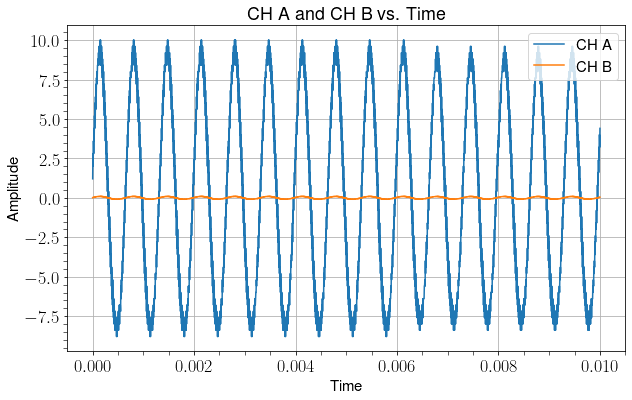

In [4]:
#Plot daempfung
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(time_array, channelA_damp, label='CH A',marker=None)
plt.plot(time_array, channelB_damp, label='CH B',marker=None)

# Add labels and a legend
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()

# Show the plot
plt.grid(True)
plt.title('CH A and CH B vs. Time')
plt.show()

Maximalwert ohne Dämpfung: 8.741976821930711
Maximalwert mit Dämpfung: 0.08741976805089068
Dämpfung: 100.00000019265258
Fehler auf die Dämpfung 0.16177274231470887


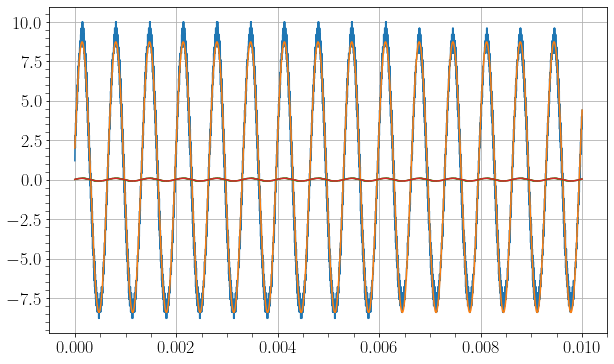

In [25]:
def fit_sin(p0,x,y):
    fit = curve_fit(my_sin, x, y, p0=p0)
    data_fit = my_sin(x, *fit[0])
    return data_fit

# Funktion die wir fitten
def my_sin(x, freq, amplitude, phase, offset):
    return np.sin(x * freq + phase) * amplitude + offset

# Anfangswerte für den fit (geraten)   
#p0=[guess_freq, guess_amplitude, guess_phase, guess_offset]
p0_dampA = [59600/(2*pi), 10, 0.15, 0]
p0_dampB = [59600/(2*pi), 0.1, 0.15, 0]

# Plots
plt.figure(figsize=(10, 6))

plt.plot(time_array,channelA_damp)
plt.plot(time_array,fit_sin(p0_dampA,time_array,channelA_damp))

plt.plot(time_array,channelB_damp)
plt.plot(time_array,fit_sin(p0_dampB,time_array,channelB_damp))

# Amplituden
amp_damp_A = np.max(fit_sin(p0_dampA,time_array,channelA_damp))
amp_damp_B = np.max(fit_sin(p0_dampB,time_array,channelB_damp))

#printing
print("Maximalwert ohne Dämpfung:",amp_damp_A)
print("Maximalwert mit Dämpfung:",amp_damp_B)
print("Dämpfung:",amp_damp_A/amp_damp_B)
print("Fehler auf die Dämpfung",einfachGaussMult(np.array([1,0.01]),
                                np.array([amp_damp_A,amp_damp_B]) , np.array([1,-1])))

### DATEN VERARBEITEN & FIT BERECHNEN

In [ ]:
# Eigene Notizen: 0.02 0.034 12/29 20/29 12-94

# Anfangs und Endwert des Signals bestimmen
timeWindow = time[int(len(time)*11.5/29):int(len(time)*19.3/29)]  
channelBWindow = channelB[int(len(channelB)*11.5/29):int(len(channelB)*19.3/29)]  

# Abgeflachten Peaks aus Daten nehmen
timeWindowPeakAdjusted = timeWindow[109:]
timeWindowPeakAdjusted = np.concatenate((timeWindow[:30], timeWindowPeakAdjusted))
channelBWindowPeakAdjusted = channelBWindow[109:]
channelBWindowPeakAdjusted = np.concatenate((channelBWindow[:30], channelBWindowPeakAdjusted))

# Überprüfung Maximalwert um den Anfangswert raten
print(max(channelBWindowPeakAdjusted))

# Anfangswerte für den fit (geraten)
guess_freq = 2940/(2*pi)
guess_amplitude = 3.10464
guess_phase = 0.15
guess_offset = -1
p0=[guess_freq, guess_amplitude,
    guess_phase, guess_offset]

# Funktion die wir fitten
def my_sin(x, freq, amplitude, phase, offset):
    return np.sin(x * freq + phase) * amplitude + offset

# Fit ausführen mit scipy curvefit
fit = curve_fit(my_sin, timeWindowPeakAdjusted, channelBWindowPeakAdjusted, p0=p0)

# Daten die mithilfe der optimisierten Parameter erzeugt wurden
data_fit = my_sin(timeWindow, *fit[0])

print(max(data_fit))

### DATEN PLOTTEN

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14,6))

# Daten Aufzeichnen
ax.errorbar(time, channelA, xerr=0.001, yerr=0.1, capsize=0.1, elinewidth=.1, fmt='x', color="crimson", label=r'Sägezahnspannung input')
ax.errorbar(timeWindowPeakAdjusted, channelBWindowPeakAdjusted, xerr=0.001, yerr=0.1, capsize=0.1, elinewidth=.1, fmt='x', color="darkblue", label=r'Output Photodiode')

# Fitkurve aufzeichnen
ax.plot(timeWindow, data_fit)

# Titel & Achsenlabels festlegen
ax.set(title=r'Pockelseffekt aufzeichnung der Sägezahnspannung')
ax.set(xlabel=r'Zeit [s]', ylabel=r'Spannung[V]')


ax.legend()
#fig.savefig("Pockel1.pdf")

### Peaks für den zweiten Versuchsteil berechnen

In [ ]:
positivePeaks = [86.037, -73.964] # mV
positiveDiff = positivePeaks[0]-positivePeaks[1]
posSpannung = 125.8 # V
posSpannungErrSys = 0.1 #V
posSpannungErrStat = 2 #V 
print(positiveDiff)

negativePeaks = [92.036, -79.964] # mV
negativeDiff = negativePeaks[0]-negativePeaks[1]
posSpannung = 123.0 # V
posSpannungErrSys = 0.1 #V
posSpannungErrStat = 2 #V
print(negativeDiff)

# Faraday Effekt


### DATEN EINSCHREIBEN


In [ ]:
# Alle Daten aus Laborheft
stromStärke = np.arange(-5,5.5, 0.5) # [A]
stromStärkeErrSys = 0.01 # [A]

winkelDunkel = np.array([-12.2,-10.9,-9.7,-8.3,-7,-5.8,-4.4,-3.1,-1.9,-0.6,
                         0.6,2.2,3.4,4.3,6.0,7.2,8.5,9.7,11.0,12.4,13.4]) # [°]
winkelDunkelErrStat = 0.5 # [°]
winkelHell = np.array([72.7, 68.1, 76., 75.3, 78.9, 81.3, 83, 85.7, 84.9, 86.4, 88.6, 
                       91.3, 93.7, 90.0, 93.5, 94.6, 97.0, 99.6, 103.2, 105.9, 107.8])
WinkelHellErrStat = 4 # [°]
WinkelErrSys = 0.1    # [°]

winkelMaxDunkelAussen = 10.4 # [°]
winkelMaxDunkelInnen = -0.9  # [°]

# Der zweiEpsilon Winkel berechnet sich aus dem Unterschied zwischen der beiden maximal dunklen Winkeln
zweiEpsilon = winkelMaxDunkelAussen-winkelMaxDunkelInnen

### DATEN VERARBEITEN & FIT BERECHNEN

In [ ]:
# Berechnung der Bestwerte und Standardunsicherheiten der Ausgleichsgerade für die dunklen Daten
bDunkel = bestA(stromStärke, winkelDunkel)
mDunkel = bestB(stromStärke, winkelDunkel)
bDunkelErr = stuA(stromStärke, winkelDunkel)
mDunkelErr = stuB(stromStärke, winkelDunkel)

# Berechnung der Bestwerte und Standardunsicherheiten der Ausgleichsgerade für die hellen Daten
bHell = bestA(stromStärke, winkelHell)
mHell = bestB(stromStärke, winkelHell)
bHellErr = stuA(stromStärke, winkelHell)
mHellErr = stuB(stromStärke, winkelHell)

# Ausgabe der Bestwerte und Standardunsicherheiten der Ausgleichsgerade für die dunklen Daten
print("Dunkel für m*x+b:\n")
print('('+str(mDunkel)+'+-'+str(mDunkelErr)+')*x + '+str(bDunkel)+'+-'+str(bDunkelErr))

# Ausgabe der Bestwerte und Standardunsicherheiten der Ausgleichsgerade für die hellen Daten
print("Hell für m*x+b:\n")
print('('+str(mHell)+'+-'+str(mHellErr)+')*x + '+str(bHell)+'+-'+str(bHellErr))

### DATEN PLOTTEN

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(14,12))

# Daten Aufzeichnen
ax[0].errorbar(stromStärke, winkelDunkel, xerr=stromStärkeErrSys, yerr=winkelDunkelErrStat, 
            capsize=0.1, elinewidth=.1, fmt='x', color="red", label=r'Datenpunkte Dunkel')
ax[1].errorbar(stromStärke, winkelHell, xerr=stromStärkeErrSys, yerr=WinkelHellErrStat, 
            capsize=0.1, elinewidth=.1, fmt='x', color="blue", label=r'Datenpunkte Hell')

# Fitkurve aufzeichnen
ax[0].plot(stromStärke, stromStärke*mDunkel+bDunkel, color="crimson", label=r'Ausgleichsgerade Dunkel')
ax[0].plot(stromStärke, stromStärke*(mDunkel+mDunkelErr)+bDunkel-bDunkelErr, color='tab:red', ls='dashed', label=r'Grenzgeraden Dunkel')
ax[0].plot(stromStärke, stromStärke*(mDunkel-mDunkelErr)+bDunkel+bDunkelErr, color='tab:red', ls='dashed')

ax[1].plot(stromStärke, stromStärke*mHell+bHell, color="darkblue", label=r'Ausgleichsgerade Hell')
ax[1].plot(stromStärke, stromStärke*(mHell+mHellErr)+bHell-bHellErr, color='tab:blue', ls='dashed', label=r'Grenzgeraden Hell')
ax[1].plot(stromStärke, stromStärke*(mHell-mHellErr)+bHell+bHellErr, color='tab:blue', ls='dashed')

# Titel & Achsenlabels festlegen
ax[0].set(title=r'Stromstärkenabhängige Winkeländerung')
ax[0].set(xlabel=r'', ylabel=r'Winkel [°]')
ax[1].set(xlabel=r'Stromstärke [A]', ylabel=r'Winkel [°]')


ax[0].legend()
ax[1].legend()
#fig.savefig("Faraday1.pdf")